The Kalman filter estimates time-varying exposures from noisy returns using a linear Gaussian state-space model. Let:



### Model Overview

| Symbol                   | Dimensions       | Description |
|--------------------------|------------------|-------------|
| $\beta_t$                | $1 \times K$     | **Latent exposures** to $K$ risk factors at time $t$. Represents the portfolio’s sensitivities to each factor. Each element is a time-varying regression coefficient. |
| $y_t$                    | $1 \times 1$     | **Observed return** of the mutual fund at time $t$. This is the actual return we aim to explain. |
| $H_t$                    | $1 \times K$     | **Factor returns** at time $t$. Observed vector of benchmark or index returns. |
| $T$                      | $K \times K$     | **State transition matrix**. Controls how exposures evolve from $t{-}1$ to $t$. For a random walk: $T = I_K$. |
| $Q$                      | $K \times K$     | **State noise covariance**. Governs how volatile the exposure dynamics are. Higher values imply more flexibility. |
| $R$                      | $1 \times 1$     | **Observation noise variance**. Captures residual risk or model error in returns. |
| $P_{t\vert s}$           | $K \times K$     | **Covariance of** $\beta_t$ **given data up to time** $s$. Reflects uncertainty in the exposure estimate. |
| $\hat{\beta}_{t\vert s}$ | $1 \times K$     | **Estimate of** $\beta_t$ **given data up to time** $s$. Prior if $s = t{-}1$; posterior if $s = t$. |
| $S_t$                    | $1 \times 1$     | **Innovation covariance**. Total uncertainty in the predicted return. |


### Kalman Filter Derivation: Time-Varying Factor Exposures

---

#### **State Equation**

$$
\beta_t = T \beta_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, Q)
$$

> The latent exposure vector $\beta_t$ evolves as a linear Gaussian process.  
> If $T = I_K$, this is a random walk where exposures change only via process noise $\eta_t$.  
> A larger $Q$ implies greater allowed variation in exposures over time.

---

#### **Observation Equation**

$$
y_t = H_t \beta_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, R)
$$

> The return $y_t$ is a noisy linear combination of factor exposures.  
> The noise $\epsilon_t$ captures residuals — alpha, model error, or idiosyncratic risk.  
> A larger $R$ means we trust the return signal less when estimating exposures.

---

#### **Prediction Step**

$$
\hat{\beta}_{t \vert t-1} = T \hat{\beta}_{t-1 \vert t-1}
$$

$$
P_{t \vert t-1} = T P_{t-1 \vert t-1} T^\top + Q
$$

> These equations forecast the next exposure vector and its uncertainty.  
> The covariance grows with $Q$, which encodes how volatile we expect exposures to be.

---

#### **Update Step**

**Innovation (Residual):**
$$
\tilde{y}_t = y_t - H_t \hat{\beta}_{t \vert t-1}
$$

> This is the prediction error — how far the model return is from the observed return.

**Innovation Covariance:**
$$
S_t = H_t P_{t \vert t-1} H_t^\top + R
$$

> Total variance in the predicted return, combining uncertainty from $\beta_t$ and observation noise $R$.

**Kalman Gain:**
$$
K_t = P_{t \vert t-1} H_t^\top S_t^{-1}
$$

> The Kalman gain determines how much to update the state based on the new observation.  
> - Higher $Q$ → larger $P_{t \vert t-1}$ → **more trust in the new measurement**.  
> - Higher $R$ → larger $S_t$ → **less trust in the new measurement**.

---

#### **Posterior (Update) Step**

**Posterior Mean:**
$$
\hat{\beta}_{t \vert t} = \hat{\beta}_{t \vert t-1} + K_t \tilde{y}_t
$$

> The updated exposure estimate adjusts the prior based on new information.  
> The correction term $K_t \tilde{y}_t$ reflects how surprising the return was, scaled by how much we trust the data relative to the model.

**Posterior Covariance:**
$$
P_{t \vert t} = (I_K - K_t H_t) P_{t \vert t-1}
$$

> Posterior uncertainty shrinks in directions where $H_t$ was informative.  
> The Kalman filter recursively reduces uncertainty as new data arrives.

---

The Kalman filter blends **model-based prediction** with **data-driven correction**.  
- High process noise ($Q$) -> more weight on observed returns (adaptive exposures).  
- High observation noise ($R$) -> more weight on model (stable exposures).



## 1. Standard Kalman Filter

**Use Case**: Linear-Gaussian systems (e.g., time-varying factor exposures)

**Equations:**
$$
\beta_t = T \beta_{t-1} + w_t \\
y_t = H_t \beta_t + v_t \\
w_t \sim \mathcal{N}(0, Q), \quad v_t \sim \mathcal{N}(0, R)
$$

**Pros**: Fast, optimal under Gaussian assumptions  
**Cons**: Sensitive to Q/R scale, rigid dynamics

---

## 2. Extended Kalman Filter (EKF)

**Use Case**: Mildly non-linear systems

**Key Idea**: Linearizes non-linear functions around current estimate using Jacobians.

**Pros**: Handles small non-linearities  
**Cons**: Approximate; poor in strongly non-linear settings

---

## 3. Unscented Kalman Filter (UKF)

**Use Case**: Strong non-linearity in dynamics or observations

**Key Idea**: Uses sigma points to better capture mean/covariance evolution without linearization.

**Pros**: More accurate than EKF  
**Cons**: Slower, more complex

---

## 4. Particle Filter

**Use Case**: Non-Gaussian, non-linear systems (e.g., regime-switching models)

**Key Idea**: Approximates posteriors using weighted samples (particles)

**Pros**: Ultimate flexibility, handles multimodal distributions  
**Cons**: Computationally expensive, resampling complexity

---

## 5. Bayesian Kalman Filter (e.g., PyMC)

**Use Case**: Posterior inference over $\beta_t$, $Q$, $R$ with prior uncertainty

**Key Idea**: Use MCMC or variational inference to estimate full posterior

**Pros**: Credible intervals, prior constraints, non-Gaussian noise (e.g., Student-t)  
**Cons**: Slower, requires model tuning and sampling

---

## 6. Constrained Kalman Filter

**Use Case**: Known constraints (e.g., $\beta_t \geq 0$ for duration)

**Key Idea**: Projects updates back into feasible region after standard step

**Pros**: Enforces real-world bounds  
**Cons**: Breaks Gaussian assumptions, approximate




In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import argparse
import logging
import time
import pymc as pm
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

import utils.utils as utils
import plotly.graph_objects as go
from utils.viz_utils import get_sci_template, attach_line_end_labels
from filters.kalman import KalmanSpec, KalmanEngine
from post_run.kalman_explore import (ModelDiagnosticsPlotter, 
                            summarize_model_diagnostics, 
                            summarize_factor_dynamics, 
                            plot_beta_grid, 
                            plot_factor_contributions,
                            run_kalman_grid_search,
                            ModelComparisonEngine,
                            )
import numpy as np
import pandas as pd

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [1]:
import pandas as pd
import numpy as np

# Sample input data (you'd replace this with your real data)
np.random.seed(0)
T = 100
data = pd.DataFrame({
    'c_A': np.random.normal(0.0005, 0.001, T),
    'c_B': np.random.normal(0.0003, 0.0008, T),
    'r_m': np.random.normal(0.0006, 0.0012, T)
})

# Portfolio return
data['r_p'] = data['c_A'] + data['c_B']

# Rolling window size
window = 30

# Rolling variance of the market
var_m = data['r_m'].rolling(window).var()

# Covariances with the market
cov_p_m = data[['r_p', 'r_m']].rolling(window).cov().unstack().iloc[:,1]
cov_A_m = data[['c_A', 'r_m']].rolling(window).cov().unstack().iloc[:,1]
cov_B_m = data[['c_B', 'r_m']].rolling(window).cov().unstack().iloc[:,1]

# Compute rolling betas
data['beta_p'] = cov_p_m / var_m
data['beta_A'] = cov_A_m / var_m
data['beta_B'] = cov_B_m / var_m

# Check decomposition
data['beta_check'] = data['beta_A'] + data['beta_B']

# Optional: check numerical error
assert np.allclose(data['beta_p'].dropna(), data['beta_check'].dropna(), atol=1e-6)


AssertionError: 

In [2]:
# import yfinance as yf
# import pandas as pd

# tickers = [
#     "FPE", "PFF", "PGX", "PSK", "PFFA", "PFXF", "VRP", "HYG", "ICVT", "LQD", 'IEF', "TLT",
# ]
# raw = yf.download(tickers, start="2012-01-01", auto_adjust=False)
# adj_close = raw["Adj Close"]
# returns = adj_close.pct_change()
# returns.to_csv("data/adj_close_returns_etfs.csv")
# print(returns.head())

# etf_names = {
#     "FPE": "First Trust Preferred Securities and Income ETF",
#     "PFF": "iShares Preferred and Income Securities ETF",
#     "PGX": "Invesco Preferred ETF",
#     "PSK": "SPDR Wells Fargo Preferred Stock ETF",
#     "PFFA": "Virtus InfraCap U.S. Preferred Stock ETF",
#     "PFXF": "VanEck Preferred Securities ex Financials ETF",
#     "VRP": "Invesco Variable Rate Preferred ETF",
#     "HYG": "iShares iBoxx $ High Yield Corporate Bond ETF",
#     "ICVT": "iShares Convertible Bond ETF",
#     "LQD": "iShares iBoxx $ Investment Grade Corporate Bond ETF",
#     "IEF": "iShares 7-10 Year Treasury Bond ETF",
#     "TLT": "iShares 20+ Year Treasury Bond ETF"
# }



In [3]:
bond_return_data = pd.read_csv("data/bond_factor_returns.csv", index_col=0, parse_dates=True)
bond_return_data = bond_return_data.loc["2016-01-01":"2023-01-01"]
#bond_return_data = bond_return_data.drop(columns=['PFFA'])

yield_data = pd.read_csv("data/daily-treasury-rates.csv", index_col=0, parse_dates=True).sort_index()
yield_delta = yield_data.diff().drop(columns=['2 Mo', '4 Mo'])
yield_delta.columns = [f"{col}_delta" for col in yield_delta.columns]
yield_delta = yield_delta.dropna()
merged_data = bond_return_data.merge(yield_delta, left_index=True, right_index=True, how="left")
data_weekly = utils.aggregate_weekly_data(merged_data, additive_cols=yield_delta.columns,)
# Convert all columns in data_weekly that are not yield delta columns to basis points (multiply by 100)
yield_delta_cols = yield_delta.columns
cols_to_convert = [col for col in data_weekly.columns if col not in yield_delta_cols]
# data_weekly[cols_to_convert] = data_weekly[cols_to_convert] * 1e4
# data_weekly[yield_delta_cols] = data_weekly[yield_delta_cols] * 100

data_weekly = data_weekly.sort_values(by="Date")
data_weekly

,Preferred Income (FPE),High Yield (HYG),Convertibles (ICVT),Investment Grade (LQD),Preferred Stock (PFF),1 Mo_delta,3 Mo_delta,6 Mo_delta,1 Yr_delta,2 Yr_delta,3 Yr_delta,5 Yr_delta,7 Yr_delta,10 Yr_delta,20 Yr_delta,30 Yr_delta
Date,,,,,,,,,,,,,,,,
2016-01-08,-0.001056,-0.013155,-0.038062,0.005526,-0.000258,0.06,0.04,-0.04,-0.01,-0.12,-0.11,-0.19,-0.18,-0.14,-0.12,-0.10
2016-01-15,-0.004226,-0.020245,-0.052727,-0.004361,-0.015963,-0.01,0.04,-0.08,-0.15,-0.09,-0.12,-0.11,-0.12,-0.10,-0.11,-0.10
2016-01-22,-0.004227,0.011808,-0.007917,-0.005257,-0.000262,0.07,0.07,0.04,-0.02,0.03,0.03,0.03,0.02,0.04,0.02,0.02
2016-01-29,0.005362,0.005836,-0.006046,0.005373,0.006804,-0.04,0.02,0.02,0.00,-0.12,-0.14,-0.16,-0.14,-0.13,-0.10,-0.08
2016-02-05,-0.010133,-0.018999,-0.002559,-0.003541,-0.010837,0.01,-0.03,0.02,0.08,-0.02,-0.06,-0.08,-0.09,-0.08,-0.09,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-02,0.005297,0.011598,0.014257,0.018562,0.016451,-0.25,-0.07,-0.02,-0.07,-0.14,-0.21,-0.18,-0.17,-0.17,-0.18,-0.18
2022-12-09,-0.004684,-0.006882,-0.017483,-0.005118,-0.030979,-0.10,-0.03,0.07,0.03,0.05,0.08,0.08,0.08,0.06,0.03,0.00
2022-12-16,0.005294,-0.000634,-0.003058,0.004876,-0.001598,0.13,0.00,-0.04,-0.11,-0.16,-0.16,-0.14,-0.11,-0.09,-0.09,-0.03


In [4]:
# --- Inspect Results ---Ca

# --- Define Target and Factor (PFF now used as factor) ---
target_col = "Preferred Income (FPE)"  # Example target
factor_cols = ['Preferred Stock (PFF)', 'Convertibles (ICVT)']  # PFF as factor

y = data_weekly[target_col]
H = data_weekly[factor_cols]
index = data_weekly.index

# --- Build Kalman Spec ---
spec = (
    KalmanSpec(K=len(factor_cols), name='Test Model')
    #.set_initial_state_from_ols(H, y)
    #.set_Q_from_factor_vols(H)
    #.set_intercept()

    #.set_Q_from_rolling_beta_var(df=data_weekly, target_col=target_col, factor_cols=factor_cols, window=12)
    #.set_Q_from_rolling_residual_vol(df=data_weekly, target_col=target_col, factor_cols=factor_cols, window=12)
    #.set_R_from_ols(H=H, y=y)
    .set_R_from_rolling_ols_residuals(df=data_weekly, target_col=target_col, factor_cols=factor_cols, window=12)
    #.set_R_from_rolling_factor_vols(H, window=12, )
)

# --- Run Kalman Filter ---
engine = KalmanEngine(spec)
results = KalmanEngine(spec).run(data_weekly, 
target_col= target_col, 
factor_cols=factor_cols, 
burn=8
)

viz = ModelDiagnosticsPlotter(results)
fig = viz.plot(include=None)  # uses default diagnostics: residuals, log_likelihood, gain_norm
display(fig)
df_factors = summarize_model_diagnostics(results)
display(df_factors.style.format(precision=4))  # control formatting here, not in the function
#display(plot_factor_contributions(results, ))

display(summarize_factor_dynamics(results).style.format(precision=4))

fig = plot_beta_grid(results)
display(fig)

,Model Name,Target,Date Range,# Observations,Final RMSE,Mean RMSE,Total SSE,Cumulative Log-Likelihood,Mean Gain Norm,Mean Drift Norm
0,Test Model,Preferred Income (FPE),2016-03-04 → 2022-12-30,357,0.0063,0.0063,0.0141,1256.1453,5.0406,0.0156


,Model Name,Target,Factor,Avg Beta,Beta Std,Final Beta,Beta Z-Score,Min Beta,Max Beta,Drift Volatility,Mean Gain,Avg Contribution,Final Contribution
0,Test Model,Preferred Income (FPE),Preferred Stock (PFF),0.5277,0.1590,0.4767,-0.3203,0.2619,0.8688,0.0235,0.1621,0.0005,-0.0033
1,Test Model,Preferred Income (FPE),Convertibles (ICVT),0.0556,0.0748,0.0397,-0.2124,-0.0791,0.3410,0.0166,0.4893,0.0003,-0.0001


In [5]:
grid_results = run_kalman_grid_search(
    df=data_weekly,
    target_col=target_col,
    factor_cols=factor_cols,
    base_spec=KalmanSpec(K=len(factor_cols)),
    burn=24
)

In [6]:
engine = ModelComparisonEngine(df=data_weekly, fund_cols=['Preferred Income (FPE)', 'High Yield (HYG)'], 
factor_cols=['Preferred Stock (PFF)', 'Convertibles (ICVT)'], burn=12)
engine.run_all()  # optional: pass your own q_setters/r_setters

all_results = engine.get_all_summaries()
exposure_df = engine.compare_exposures()

Running Kalman filter for Preferred Income (FPE)...
Running Kalman filter for High Yield (HYG)...


In [7]:
fig = engine.plot_all_stacked_betas(show_std=False)
fig

In [8]:
# pymc_kalman_pipeline.py

import pymc as pm
import aesara.tensor as at
import numpy as np
import pandas as pd
import arviz as az
from typing import Optional, Callable, Union
from dataclasses import dataclass

# ----------------------------
# Synthetic Data Generator
# ----------------------------
def simulate_kalman_data(T=100, K=2, seed=42):
    np.random.seed(seed)
    beta_true = np.zeros((T, K))
    beta_true[0] = np.random.normal(0, 0.5, size=K)
    for t in range(1, T):
        beta_true[t] = beta_true[t - 1] + np.random.normal(0, 0.1, size=K)

    H = np.random.normal(0, 1, size=(T, K))
    mu = np.sum(H * beta_true, axis=1)
    y = mu + np.random.standard_t(df=4, size=T) * 0.5
    index = pd.date_range("2020-01-01", periods=T, freq="D")
    return pd.Series(y, index=index, name="y"), pd.DataFrame(H, index=index, columns=[f"x{i+1}" for i in range(K)]), beta_true

# ----------------------------
# PyMC Kalman Spec
# ----------------------------
@dataclass
class PyMCKalmanSpec:
    nu_prior: Callable = lambda: pm.Exponential("nu", lam=1.0)
    r_sigma_prior: Callable = lambda: pm.HalfNormal("r_sigma", sigma=1.0)
    q_sigma_prior: Callable = lambda shape: pm.HalfNormal("q_sigma", sigma=0.1, shape=shape)
    constrained: bool = False

# ----------------------------
# PyMC Kalman Engine
# ----------------------------
class PyMCKalmanEngine:
    def __init__(self, spec: PyMCKalmanSpec):
        self.spec = spec

    def build_model(self, y: pd.Series, H: pd.DataFrame):
        T, K = H.shape
        with pm.Model() as model:
            # Priors
            nu = self.spec.nu_prior()
            r_sigma = self.spec.r_sigma_prior()
            q_sigma = self.spec.q_sigma_prior(K)

            # Random Walk on beta
            beta = pm.GaussianRandomWalk("beta", sigma=q_sigma, shape=(T, K))
            if self.spec.constrained:
                beta = pm.Deterministic("beta_constrained", at.clip(beta, -2.0, 2.0))

            # Linear predictor
            beta_used = beta if not self.spec.constrained else model["beta_constrained"]
            mu = at.sum(H.values * beta_used, axis=1)

            # Observation
            pm.StudentT("y_obs", nu=nu, mu=mu, sigma=r_sigma, observed=y.values)

        return model

    def run(self, y: pd.Series, H: pd.DataFrame, draws=1000, tune=1000, chains=2, target_accept=0.9):
        model = self.build_model(y, H)
        with model:
            trace = pm.sample(draws=draws, tune=tune, chains=chains, target_accept=target_accept, return_inferencedata=True)
        return trace

# ----------------------------
# Beta Summary Tool
# ----------------------------
def summarize_beta(trace: az.InferenceData, y: pd.Series, H: pd.DataFrame) -> pd.DataFrame:
    beta_samples = trace.posterior["beta"]  # shape: [chain, draw, time, K]
    beta_mean = beta_samples.mean(dim=("chain", "draw"))
    beta_df = pd.DataFrame(
        beta_mean.values, index=y.index, columns=H.columns
    )
    return beta_df

# ----------------------------
# Example Usage
# ----------------------------
if __name__ == "__main__":
    y, H, beta_true = simulate_kalman_data(T=150, K=2)

    spec = PyMCKalmanSpec(constrained=True)
    engine = PyMCKalmanEngine(spec)
    trace = engine.run(y, H, draws=1000, tune=1000, chains=2)

    beta_summary = summarize_beta(trace, y, H)
    print(beta_summary.head())

    az.plot_trace(trace, var_names=["r_sigma", "nu"]);
    az.plot_forest(trace, var_names=["q_sigma"]);
    az.plot_posterior(trace, var_names=["r_sigma", "nu"]);

ModuleNotFoundError: No module named 'distutils.msvccompiler'

In [22]:
# pymc_kalman_pipeline.py

import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
from typing import Optional, Callable, Union
from dataclasses import dataclass
import pytensor.tensor as at


# ----------------------------
# Synthetic Data Generator
# ----------------------------
def simulate_kalman_data(T=100, K=2, seed=42):
    np.random.seed(seed)
    beta_true = np.zeros((T, K))
    beta_true[0] = np.random.normal(0, 0.5, size=K)
    for t in range(1, T):
        beta_true[t] = beta_true[t - 1] + np.random.normal(0, 0.1, size=K)

    H = np.random.normal(0, 1, size=(T, K))
    mu = np.sum(H * beta_true, axis=1)
    y = mu + np.random.standard_t(df=4, size=T) * 0.5
    index = pd.date_range("2020-01-01", periods=T, freq="D")
    return pd.Series(y, index=index, name="y"), pd.DataFrame(H, index=index, columns=[f"x{i+1}" for i in range(K)]), beta_true

# ----------------------------
# PyMC Kalman Spec
# ----------------------------
@dataclass
class PyMCKalmanSpec:
    nu_prior: Callable = lambda: pm.Exponential("nu", lam=1.0)
    r_sigma_prior: Callable = lambda: pm.HalfNormal("r_sigma", sigma=1.0)
    q_sigma_prior: Callable = lambda shape: pm.HalfNormal("q_sigma", sigma=0.1, shape=shape)
    constrained: bool = False

# ----------------------------
# PyMC Kalman Engine
# ----------------------------
class PyMCKalmanEngine:
    def __init__(self, spec: PyMCKalmanSpec):
        self.spec = spec

    def build_model(self, y: pd.Series, H: pd.DataFrame):
        T, K = H.shape
        with pm.Model() as model:
            # Priors
            nu = self.spec.nu_prior()
            r_sigma = self.spec.r_sigma_prior()
            q_sigma = self.spec.q_sigma_prior(K)

            beta = at.stack([
                pm.GaussianRandomWalk(f"beta_{k}", sigma=q_sigma[k], shape=T)
                for k in range(K)
            ], axis=1)
            if self.spec.constrained:
                beta = pm.Deterministic("beta_constrained", pm.math.clip(beta, -2.0, 2.0))

            # Linear predictor using tensor dot
            beta_used = beta if not self.spec.constrained else model["beta_constrained"]
            H_sym = pm.Data("H", H.values.astype("float32"))
            mu = (H_sym * beta_used).sum(axis=1)

            # Observation
            pm.StudentT("y_obs", nu=nu, mu=mu, sigma=r_sigma, observed=y.values.astype("float32"))

        return model

    def run(self, y: pd.Series, H: pd.DataFrame, draws=1000, tune=1000, chains=2, target_accept=0.9):
        y = y.astype("float32")
        H = H.astype("float32")
        model = self.build_model(y, H)
        with model:
            trace = pm.sample(draws=draws, tune=tune, chains=chains, target_accept=target_accept, return_inferencedata=True)
        return trace

# ----------------------------
# Beta Summary Tool
# ----------------------------
def summarize_beta(trace: az.InferenceData, y: pd.Series, H: pd.DataFrame) -> pd.DataFrame:
    beta_samples = trace.posterior["beta"]  # shape: [chain, draw, time, K]
    beta_mean = beta_samples.mean(dim=("chain", "draw"))
    beta_df = pd.DataFrame(
        beta_mean.values, index=y.index, columns=H.columns
    )
    return beta_df

# ----------------------------
# Example Usage
# ----------------------------
if __name__ == "__main__":
    y, H, beta_true = simulate_kalman_data(T=150, K=2)

    spec = PyMCKalmanSpec(constrained=True)
    engine = PyMCKalmanEngine(spec)
    trace = engine.run(y, H, draws=1000, tune=1000, chains=2)

c:\Users\peter\anaconda3\envs\my_env\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning:

Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.

c:\Users\peter\anaconda3\envs\my_env\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning:

Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, r_sigma, q_sigma, beta_0, beta_1]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [23]:

    beta_summary = summarize_beta(trace, y, H)
    print(beta_summary.head())

    az.plot_trace(trace, var_names=["r_sigma", "nu"]);
    az.plot_forest(trace, var_names=["q_sigma"]);
    az.plot_posterior(trace, var_names=["r_sigma", "nu"]);

KeyError: "No variable named 'beta'. Did you mean one of ('beta_1', 'beta_0')?"

In [29]:
# pymc_kalman_pipeline.py

import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import pytensor.tensor as at
import plotly.graph_objects as go
from typing import Optional, Callable, Union
from dataclasses import dataclass

# ----------------------------
# Synthetic Data Generator
# ----------------------------
def simulate_kalman_data(T=100, K=2, seed=42):
    np.random.seed(seed)
    beta_true = np.zeros((T, K))
    beta_true[0] = np.random.normal(0, 0.5, size=K)
    for t in range(1, T):
        beta_true[t] = beta_true[t - 1] + np.random.normal(0, 0.1, size=K)

    H = np.random.normal(0, 1, size=(T, K))
    mu = np.sum(H * beta_true, axis=1)
    y = mu + np.random.standard_t(df=4, size=T) * 0.5
    index = pd.date_range("2020-01-01", periods=T, freq="D")
    return pd.Series(y, index=index, name="y"), pd.DataFrame(H, index=index, columns=[f"x{i+1}" for i in range(K)]), beta_true

# ----------------------------
# PyMC Kalman Spec
# ----------------------------
@dataclass
class PyMCKalmanSpec:
    nu_prior: Callable = lambda: pm.Exponential("nu", lam=1.0)
    r_sigma_prior: Callable = lambda T: pm.HalfNormal("r_sigma", sigma=1.0, shape=T)
    q_sigma_prior: Callable = lambda shape: pm.HalfNormal("q_sigma", sigma=0.1, shape=shape)
    constrained: bool = False

# ----------------------------
# PyMC Kalman Engine
# ----------------------------
class PyMCKalmanEngine:
    def __init__(self, spec: PyMCKalmanSpec):
        self.spec = spec

    def build_model(self, y: pd.Series, H: pd.DataFrame):
        T, K = H.shape
        with pm.Model() as model:
            nu = self.spec.nu_prior()
            r_sigma = self.spec.r_sigma_prior(T)  # now shape [T]
            q_sigma = self.spec.q_sigma_prior((T, K))  # now shape [T, K]

            beta_components = [
                pm.GaussianRandomWalk(f"beta_{k}", sigma=q_sigma[:, k], shape=T)
                for k in range(K)
            ]
            beta = at.stack(beta_components, axis=1)
            if self.spec.constrained:
                beta = pm.Deterministic("beta_constrained", pm.math.clip(beta, -2.0, 2.0))

            beta_used = beta if not self.spec.constrained else model["beta_constrained"]
            H_sym = pm.Data("H", H.values.astype("float32"))
            mu = (H_sym * beta_used).sum(axis=1)

            pm.StudentT("y_obs", nu=nu, mu=mu, sigma=r_sigma, observed=y.values.astype("float32"))

        return model

    def run(self, y: pd.Series, H: pd.DataFrame, draws=1000, tune=1000, chains=2, target_accept=0.9):
        y = y.astype("float32")
        H = H.astype("float32")
        model = self.build_model(y, H)
        with model:
            trace = pm.sample(draws=draws, tune=tune, chains=chains, target_accept=target_accept, return_inferencedata=True)
        return trace

# ----------------------------
# Multi-Fund Comparison Engine
# ----------------------------
class PyMCModelComparisonEngine:
    def __init__(self, df: pd.DataFrame, fund_cols: list[str], factor_cols: list[str]):
        self.df = df
        self.fund_cols = fund_cols
        self.factor_cols = factor_cols
        self.results = {}

    def run_all(self, spec: PyMCKalmanSpec):
        for fund in self.fund_cols:
            y = self.df[fund]
            H = self.df[self.factor_cols]
            engine = PyMCKalmanEngine(spec)
            trace = engine.run(y, H)
            self.results[fund] = {
                "trace": trace,
                "summary": summarize_beta_with_intervals(trace, y, H),
                "spec": spec
            }

    def log_model_diagnostics(self):
        summary = []
        for fund, result in self.results.items():
            trace = result["trace"]
            loo = az.loo(trace)
            summary.append({
                "Fund": fund,
                "LOO IC": loo.loo,
                "p_LOO": loo.p_loo
            })
        return pd.DataFrame(summary)

# ----------------------------
# Posterior Summary & Plotting
# ----------------------------
def summarize_beta_with_intervals(trace: az.InferenceData, y: pd.Series, H: pd.DataFrame, interval: float = 0.95) -> pd.DataFrame:
    K = len(H.columns)
    alpha = (1 - interval) / 2

    if "beta_constrained" in trace.posterior:
        beta = trace.posterior["beta_constrained"]
    else:
        beta_names = [v for v in trace.posterior.data_vars if v.startswith("beta_")]
        beta = az.concat(trace.posterior[beta_names], dim="beta")

    mean = beta.mean(dim=("chain", "draw"))
    lower = beta.quantile(alpha, dim=("chain", "draw"))
    upper = beta.quantile(1 - alpha, dim=("chain", "draw"))

    df = pd.DataFrame({
        "time": np.tile(y.index, K),
        "factor": np.repeat(H.columns, len(y)),
        "mean": mean.values.flatten(),
        "lower": lower.values.flatten(),
        "upper": upper.values.flatten(),
    })
    return df

def plot_beta_paths(df: pd.DataFrame) -> go.Figure:
    fig = go.Figure()
    for factor in df["factor"].unique():
        sub = df[df["factor"] == factor]
        fig.add_trace(go.Scatter(x=sub["time"], y=sub["mean"], mode="lines", name=factor))
        fig.add_trace(go.Scatter(
            x=sub["time"].tolist() + sub["time"].tolist()[::-1],
            y=sub["upper"].tolist() + sub["lower"].tolist()[::-1],
            fill="toself",
            fillcolor="rgba(100,100,200,0.15)",
            line=dict(color="rgba(255,255,255,0)"),
            hoverinfo="skip",
            showlegend=False
        ))
    fig.update_layout(title="Posterior Mean and Credible Intervals for βₜ", template="simple_white")
    return fig

# ----------------------------
# Example Usage
# ----------------------------
if __name__ == "__main__":
    y, H, beta_true = simulate_kalman_data(T=150, K=2)
    df = pd.concat([y, H], axis=1)

    spec = PyMCKalmanSpec(constrained=True)
    comparison = PyMCModelComparisonEngine(df, fund_cols=["y"], factor_cols=H.columns.tolist())
    comparison.run_all(spec)

    for fund in comparison.results:
        print(f"\n{fund} beta summary:")
        print(comparison.results[fund]["summary"].head())
        fig = plot_beta_paths(comparison.results[fund]["summary"])
        fig.show()

    print("\nModel Diagnostics:")
    print(comparison.log_model_diagnostics())


c:\Users\peter\anaconda3\envs\my_env\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning:

Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.

c:\Users\peter\anaconda3\envs\my_env\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning:

Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.

Initializing NUTS using jitter+adapt_diag...


ValueError: Alloc static input type and target shape are incompatible: Vector(float32, shape=(150,)) vs (149,)

                  x1        x2
2020-01-01  0.197837 -0.107050
2020-01-02  0.205578 -0.088132
2020-01-03  0.202909 -0.096323
2020-01-04  0.204114 -0.094096
2020-01-05  0.198581 -0.086050


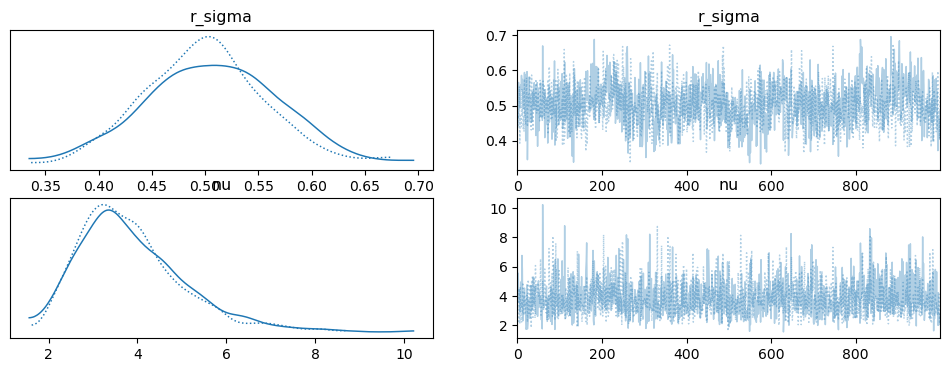

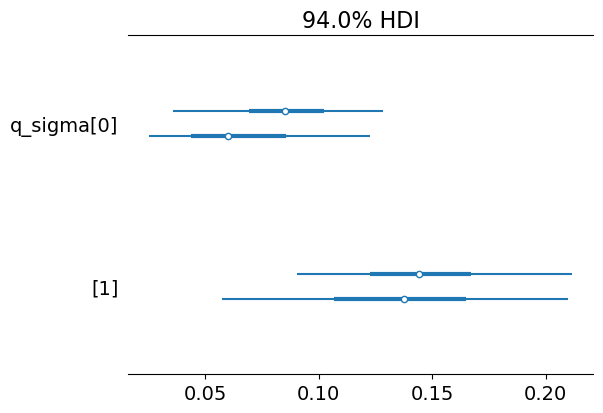

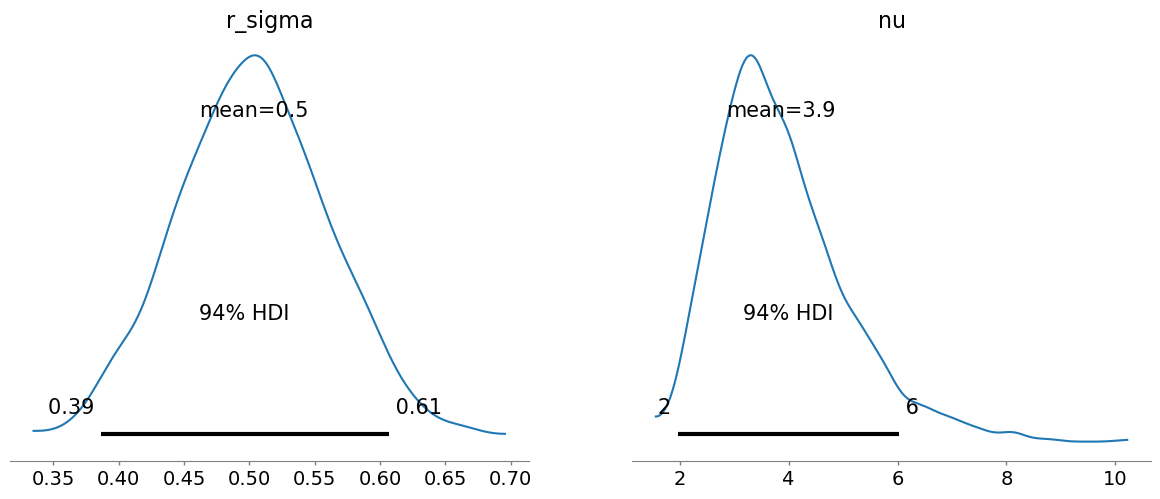

In [27]:
beta_summary = summarize_beta(trace, y, H)
print(beta_summary.head())
az.plot_trace(trace, var_names=["r_sigma", "nu"]);
az.plot_forest(trace, var_names=["q_sigma"]);
az.plot_posterior(trace, var_names=["r_sigma", "nu"]);